# Introduction

This notebook shows how to use the trained MDN models corresponding to the paper [Paper]. 

For further questions, feel free to contact the author:

[Philipp Baumeister](mailto:philipp.baumeister@tu-berlin.de)

# Imports

In [2]:
import numpy as np

import matplotlib.pyplot as plt

import keras
import mdn  # imports the MDN layer
from tensorflow_probability import distributions as tfd
import tensorflow as tf

import joblib

from scipy.stats import norm as normal

from ipywidgets import interactive
from IPython.display import display

m_e = 5.9722e24 # Earth mass
r_e = 6.371e6 # Earth radius

Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

tensorflow==1.13.1
numpy==1.16.4


# Functions

In [3]:
def plot_normal_mix(mus, sigmas, alphas, ax, color="b", label='', comp=True):
    """
    Plots the normal mixture to axis=ax
    comp=True plots all components of mixture model
    """
    x = np.linspace(0,1, 250)
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(alphas, mus, sigmas)):
        temp = normal.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, color=color, ls=":")
    ax.plot(x, final, label=label, color=color)
    return final

def unpack_predictions(prediction, components):
    """ 
    Returns mus, sigs, alphas of predictions.
    """
    return [prediction[:,i*components:(i+1)*components] for i in range(3)]

def get_normal_mix(x, alphas, mus, sigmas):
    """ 
    Returns the normal mixture for an array x and corresponding alphas, mus, sigs.
    """
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(alphas, mus, sigmas)):
        temp = normal.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
    return final

def get_file_prefix(observables):
    use_k2 = observables == "MRk2"
    print(f"Chosen model: {observables}")
    return dict(path=f"./models/{observables}", k2=use_k2)

# Load models

There are two available models to choose from, based on the number of observables they were trained with:
* Mass, radius *(default)*
* Mass, radius, fluid Love number k<sub>2</sub>

> Note: Loading the MDN model may take up to a minute

In [4]:
file = interactive(get_file_prefix, observables=[("Mass, radius", "MR"), ("Mass, radius, k2", "MRk2")])
display(file)

interactive(children=(Dropdown(description='observables', options=(('Mass, radius', 'MR'), ('Mass, radius, k2'…

In [ ]:
num_components = 20 # number of mixture components

path = file.result["path"]
print(f"Loading model {path}_mdn_model.hd5 ...")
mdn_model = keras.models.load_model(f"{path}_mdn_model.hd5", 
                                    custom_objects={"MDN": mdn.MDN, "loss_func": mdn.get_mixture_loss_func(1, num_components)})

print(f"Loading scaler {path}_scaler.pkl ...")
scaler = joblib.load(f"{path}_scaler.pkl")
print("Finished loading models")

Loading model ./models/MR_mdn_model.hd5 ...


# Predictions

This section shows how to use the model to predict a planet's possible interior structure. 

In [111]:
planet = dict(mass=1, radius=1, k2=0.933)
if file.result["k2"]:
    input_array = np.array([[np.log10(planet["mass"]*m_e)], [planet["radius"]*r_e], [planet["k2"]]])
else:
    input_array = np.array([[np.log10(planet["mass"]*m_e)], [planet["radius"]*r_e]])
scaled_input = scaler.transform(input_array.T)
prediction = mdn_model.predict(scaled_input)

## Plotting predictions

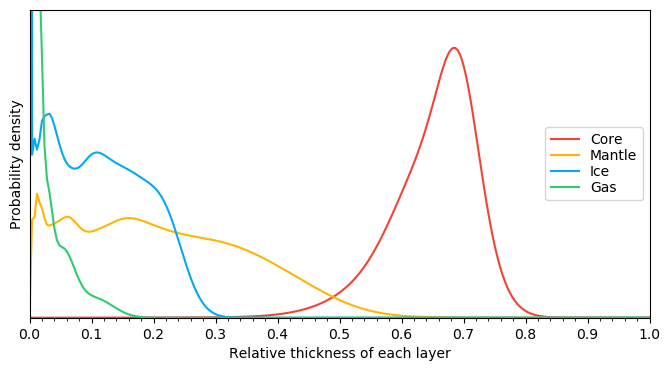

In [112]:
colors = ["#f44336", "#ffb507", "#03a9f4", "#2ecc71"]
predict_label = ["core", "mantle", "ice", "gas"]

fig = plt.figure(figsize=(8,4))
ax = fig.subplots(1, 1)

for j in range(len(prediction)):
    p = predict_label[j]
    mus, sigs, alphas = unpack_predictions(prediction[j], num_components)
    pdf = plot_normal_mix(mus[0], sigs[0], alphas[0], ax, label=p.title(), color=colors[j], comp=False)

plt.xlim(0, 1)
plt.ylim(0,8)
ax.set_xticks(np.round(np.linspace(0, 1, 11), 2))
ax.set_xticks(np.round(np.linspace(0, 1, 51), 2), minor=True)
ax.set_yticks([])
ax.set_yticklabels([])

plt.xlabel(r"Relative thickness of each layer")
plt.ylabel(r"Probability density")
plt.legend(labelspacing=0.15, loc="center right")
plt.show()

In [10]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{} >= {}".format(*r))

tensorflow >= 1.13.1
numpy >= 1.16.4
matplotlib >= 3.1.0
joblib >= 0.13.2
ipywidgets >= 7.4.2
autopep8 >= 1.4.4


In [8]:
self.__version__

NameError: name 'self' is not defined